In [1]:
import numpy as np
import jax
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import lsh_qudit.set_rccx_inverse
from lsh_qudit.validator_jax import validate_circuit
from lsh_qudit.agl import physical_states, boundary_conditions
from lsh_qudit.hamiltonian_alltoall import (mass_term, electric_12_term,
                                            electric_3f_term, electric_3b_term,
                                            hopping_term_config, hopping_term_site, prune_circuit)
from lsh_qudit.matrices import hopping_site_hamiltonian
from lsh_qudit.trotter_alltoall import trotter_step_circuit
from lsh_qudit.precompiler import lsh_qudit_precompiler

jax.config.update('jax_enable_x64', True)

## Model parameters

In [ ]:
num_sites = 6
mass_mu = Parameter(r'$\mu$')
interaction_x = Parameter('x')
time_step = Parameter(r'$\Delta$t')
# Random not-so-small numbers for numerical validation
dt = 0.73
mu = 0.37
x = 0.87

## $H_M$

$$
\begin{align*}
H_{M}(r) &= H_{M}^{(1)}(r) + H_{M}^{(2)}(r)\,, \\
H_{M}^{(1)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{i(r)}\,,\\
H_{M}^{(2)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{o(r)}\,
\end{align*}
$$

### Circuit

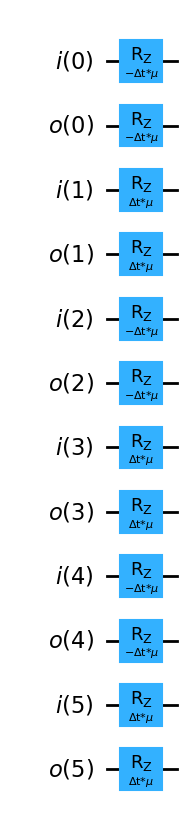

In [3]:
circuit = mass_term(num_sites, time_step, mass_mu)
circuit = prune_circuit(circuit)
circuit.draw('mpl')

## $H_E$

$$
\begin{align}
H_{E}&=H_{E}^{(1)} + H_{E}^{(2)} + H_{E}^{(3)}
\\
H_{E}^{(1)} & = \frac{1}{2}n_{l}(r)\,,
\\
H_{E}^{(2)} & = \frac{1}{4}n_{l}(r)^{2}\,,
\\
H_{E}^{(3)} & = \frac{1}{2}\left[n_{l}(r)+\frac{3}{2}\right] n_{o}(r) \left(1-n_{i}(r)\right)\,.
\end{align}
$$

### $H_E^{(1)} + H_E^{(2)} = \frac{1}{2}n_{l}(r) + \frac{1}{4}n_{l}(r)^{2}$ circuit

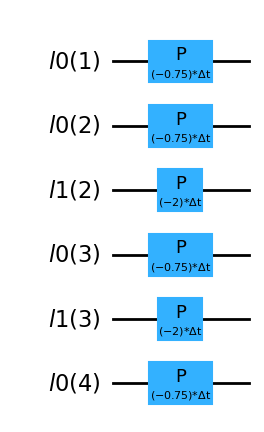

In [ ]:
circuit = electric_12_term(num_sites, time_step, max_left_flux=0, max_right_flux=0)
circuit = prune_circuit(circuit)
circuit.draw('mpl')

### $H_E^{(3f)} = \frac{3}{4} n_{o}(r) \left(1-n_{i}(r)\right)$ circuit

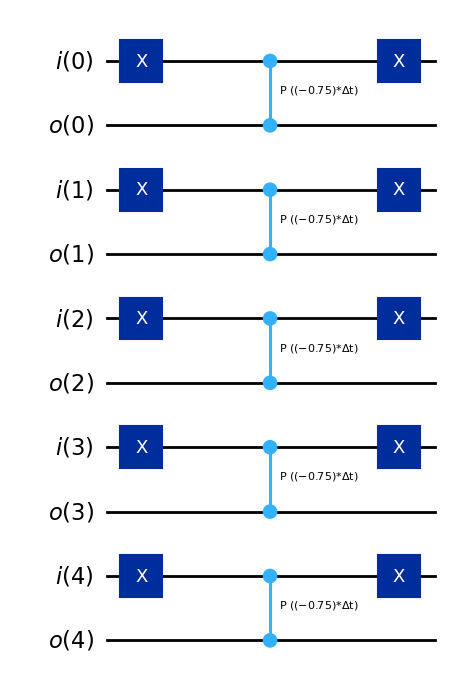

In [ ]:
circuit = electric_3f_term(num_sites, time_step)
circuit = prune_circuit(circuit)
circuit.draw('mpl')

### $H_E^{(3b)} = \frac{1}{2} n_{l}(r) n_{o}(r) \left(1 - n_{i}(r)\right)$ circuit

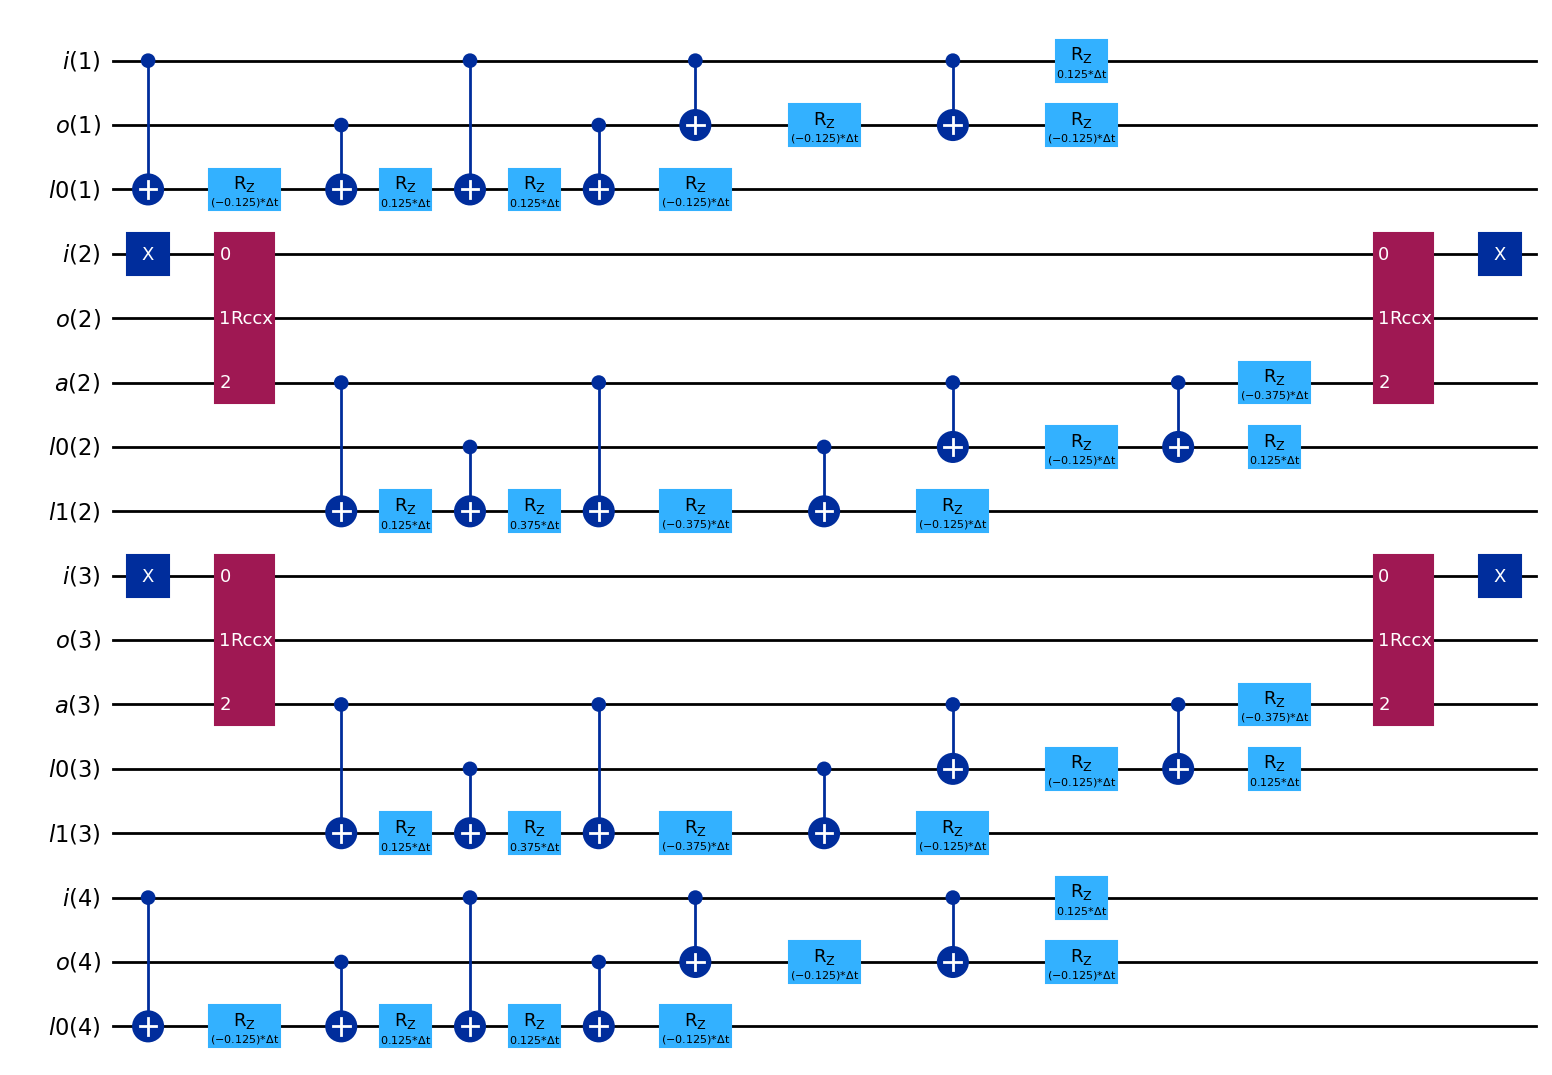

In [6]:
circuit = electric_3b_term(num_sites, time_step, max_left_flux=0, max_right_flux=0)
circuit = prune_circuit(circuit)
circuit.draw('mpl')

## $H_I$

Combinations of bosonic operators (incrementers and projectors) dictated by the boundary condition

In [ ]:
conditions = boundary_conditions(num_sites, max_left_flux=0, max_right_flux=0, num_local=2)
for term_type in [1, 2]:
    for isite in range(num_sites - 1):
        config = hopping_term_config(term_type, **conditions[isite])
        print(term_type, isite, config.boson_ops['p'], config.boson_ops['q'])

1 0 ('id', 'id') ('X', 'zero')
1 1 ('X', 'zero') ('lambda', 'id')
1 2 ('lambda', 'Lambda') ('lambda', 'Lambda')
1 3 ('lambda', 'id') ('X', 'zero')
1 4 ('X', 'zero') ('id', 'id')
2 0 ('X', 'zero') ('id', 'id')
2 1 ('lambda', 'id') ('X', 'zero')
2 2 ('lambda', 'Lambda') ('lambda', 'Lambda')
2 3 ('X', 'zero') ('lambda', 'id')
2 4 ('id', 'id') ('X', 'zero')


### $H_I^{(1)}$

The general form of $H_I^{(1)}$ is

$$
\begin{split}
\frac{1}{x} H_I^{(1)}(r) = & H_I^{(1)+}(r) + H_I^{(1)-}(r) \\
= & \ket{0}\bra{1}_{i(r)} Z_{o(r)} \ket{1}\bra{0}_{i(r+1)} \left[ \lambda^+_{l(r)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \right]^{1 - n_o(r)} \left[ \lambda^+_{l(r+1)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \right]^{n_o(r+1)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right) \\
& + \ket{1}\bra{0}_{i(r)} Z_{o(r)} \ket{0}\bra{1}_{i(r+1)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right)
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \lambda^-_{l(r)} \right]^{1 - n_o(r)}
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \lambda^-_{l(r+1)} \right]^{n_o(r+1)}
\end{split}
$$

Note that the combinations of the allowed $n_i$ and $n_o$ values together with AGL dictates that a
non-annihilated state will have $n_l(r) = n_l(r+1)$.


#### $r=0$ circuit

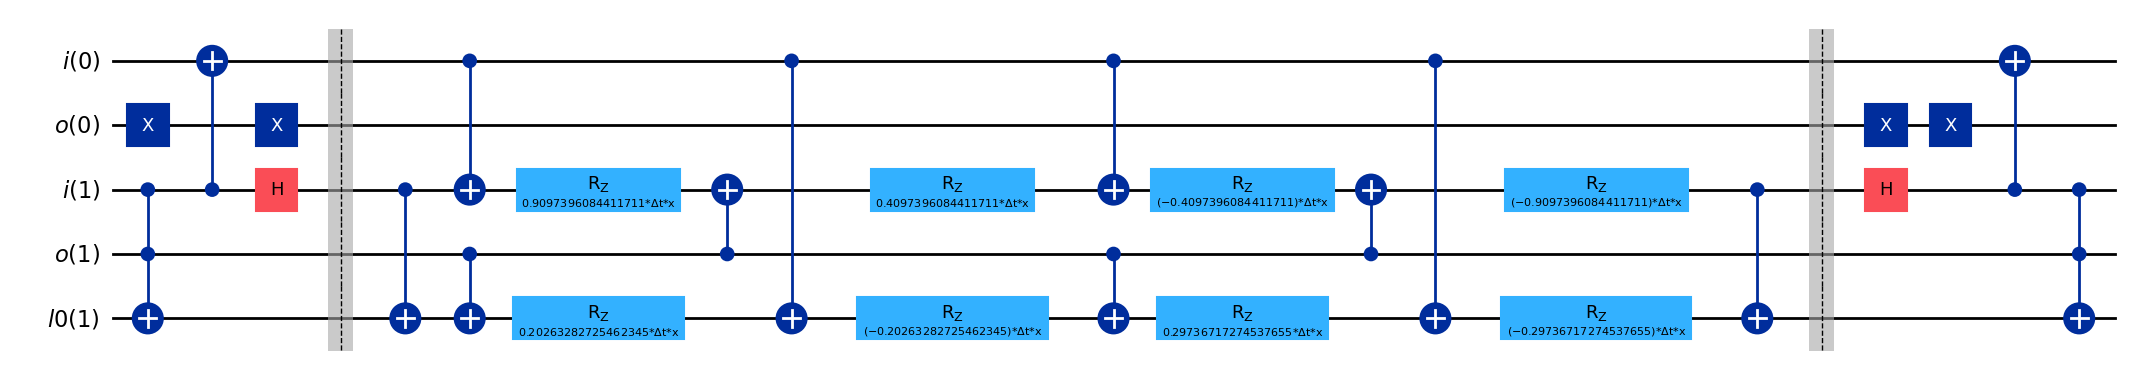

In [ ]:
circuit = hopping_term_site(time_step, 1, interaction_x, max_left_flux=0, with_barrier=True)
circuit = prune_circuit(circuit)
circuit.draw('mpl', fold=60)

#### $r=1$ circuit

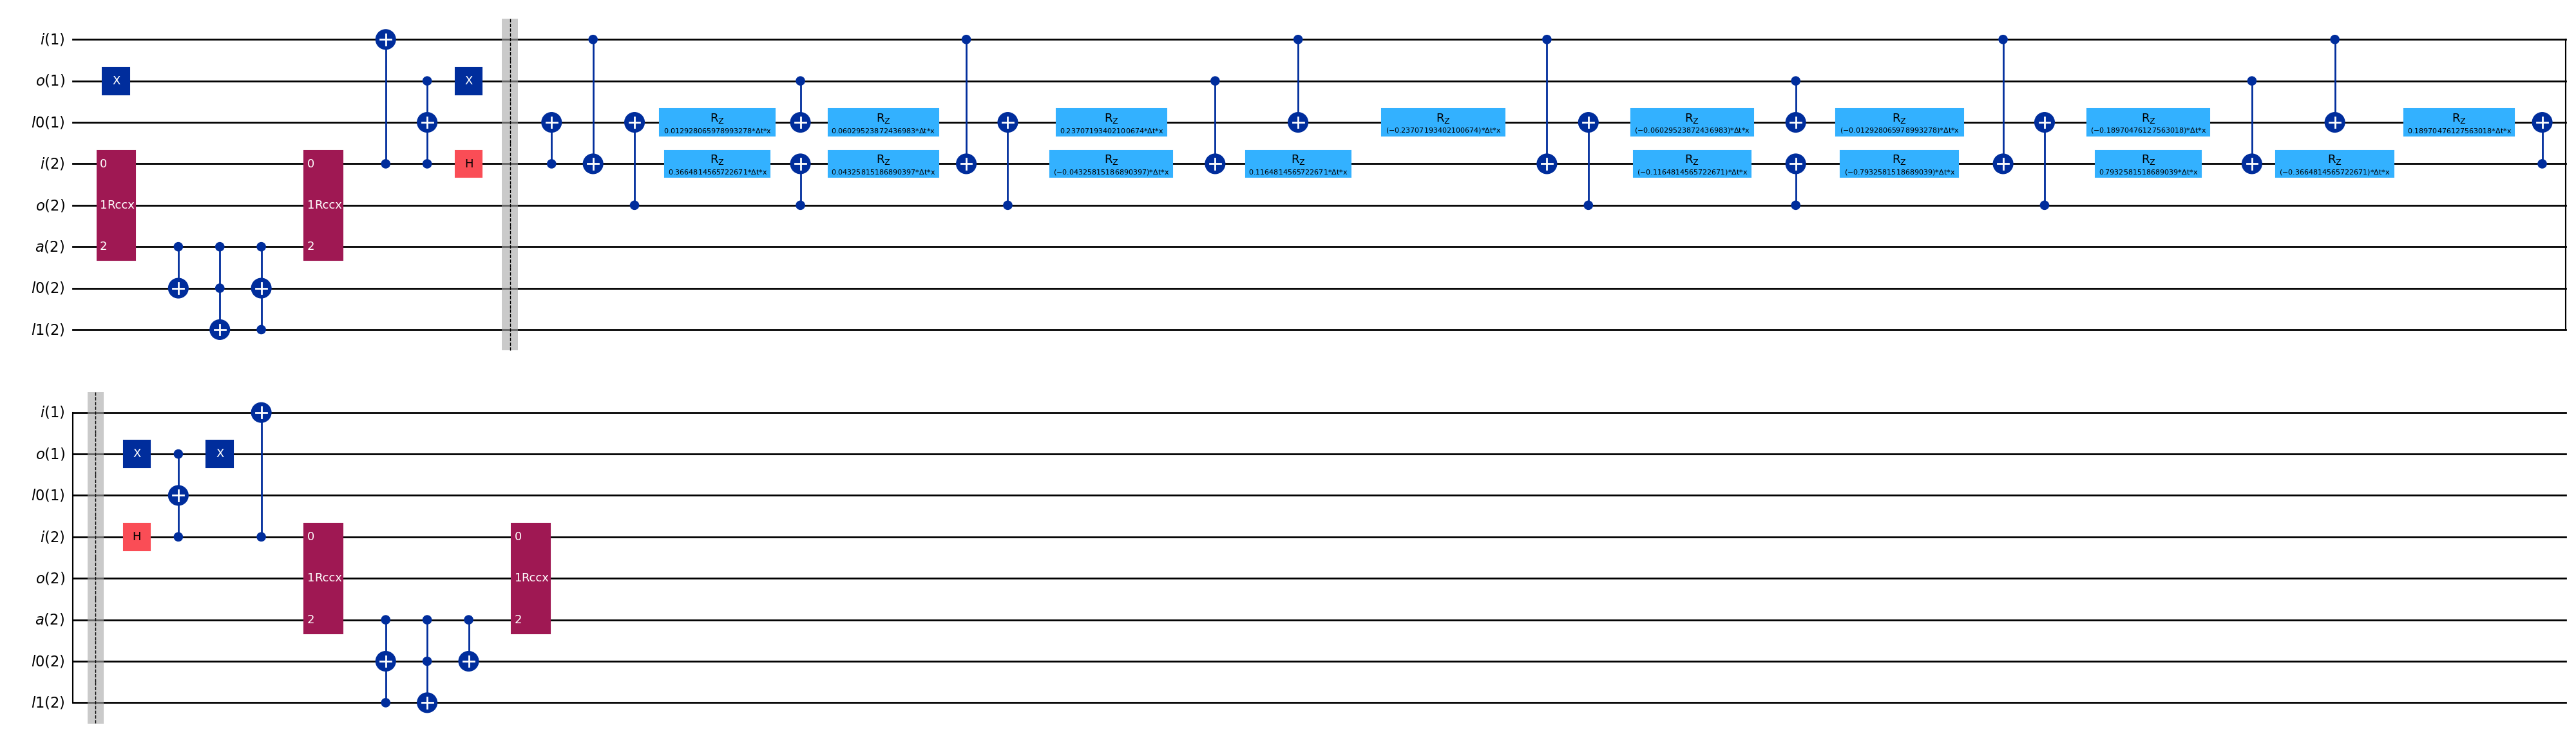

In [9]:
circuit = hopping_term_site(time_step, 1, interaction_x, max_left_flux=1, with_barrier=True)
circuit = prune_circuit(circuit, site_idx=[1, 2])
circuit.draw('mpl', fold=60)

#### $r=2,3$ circuit

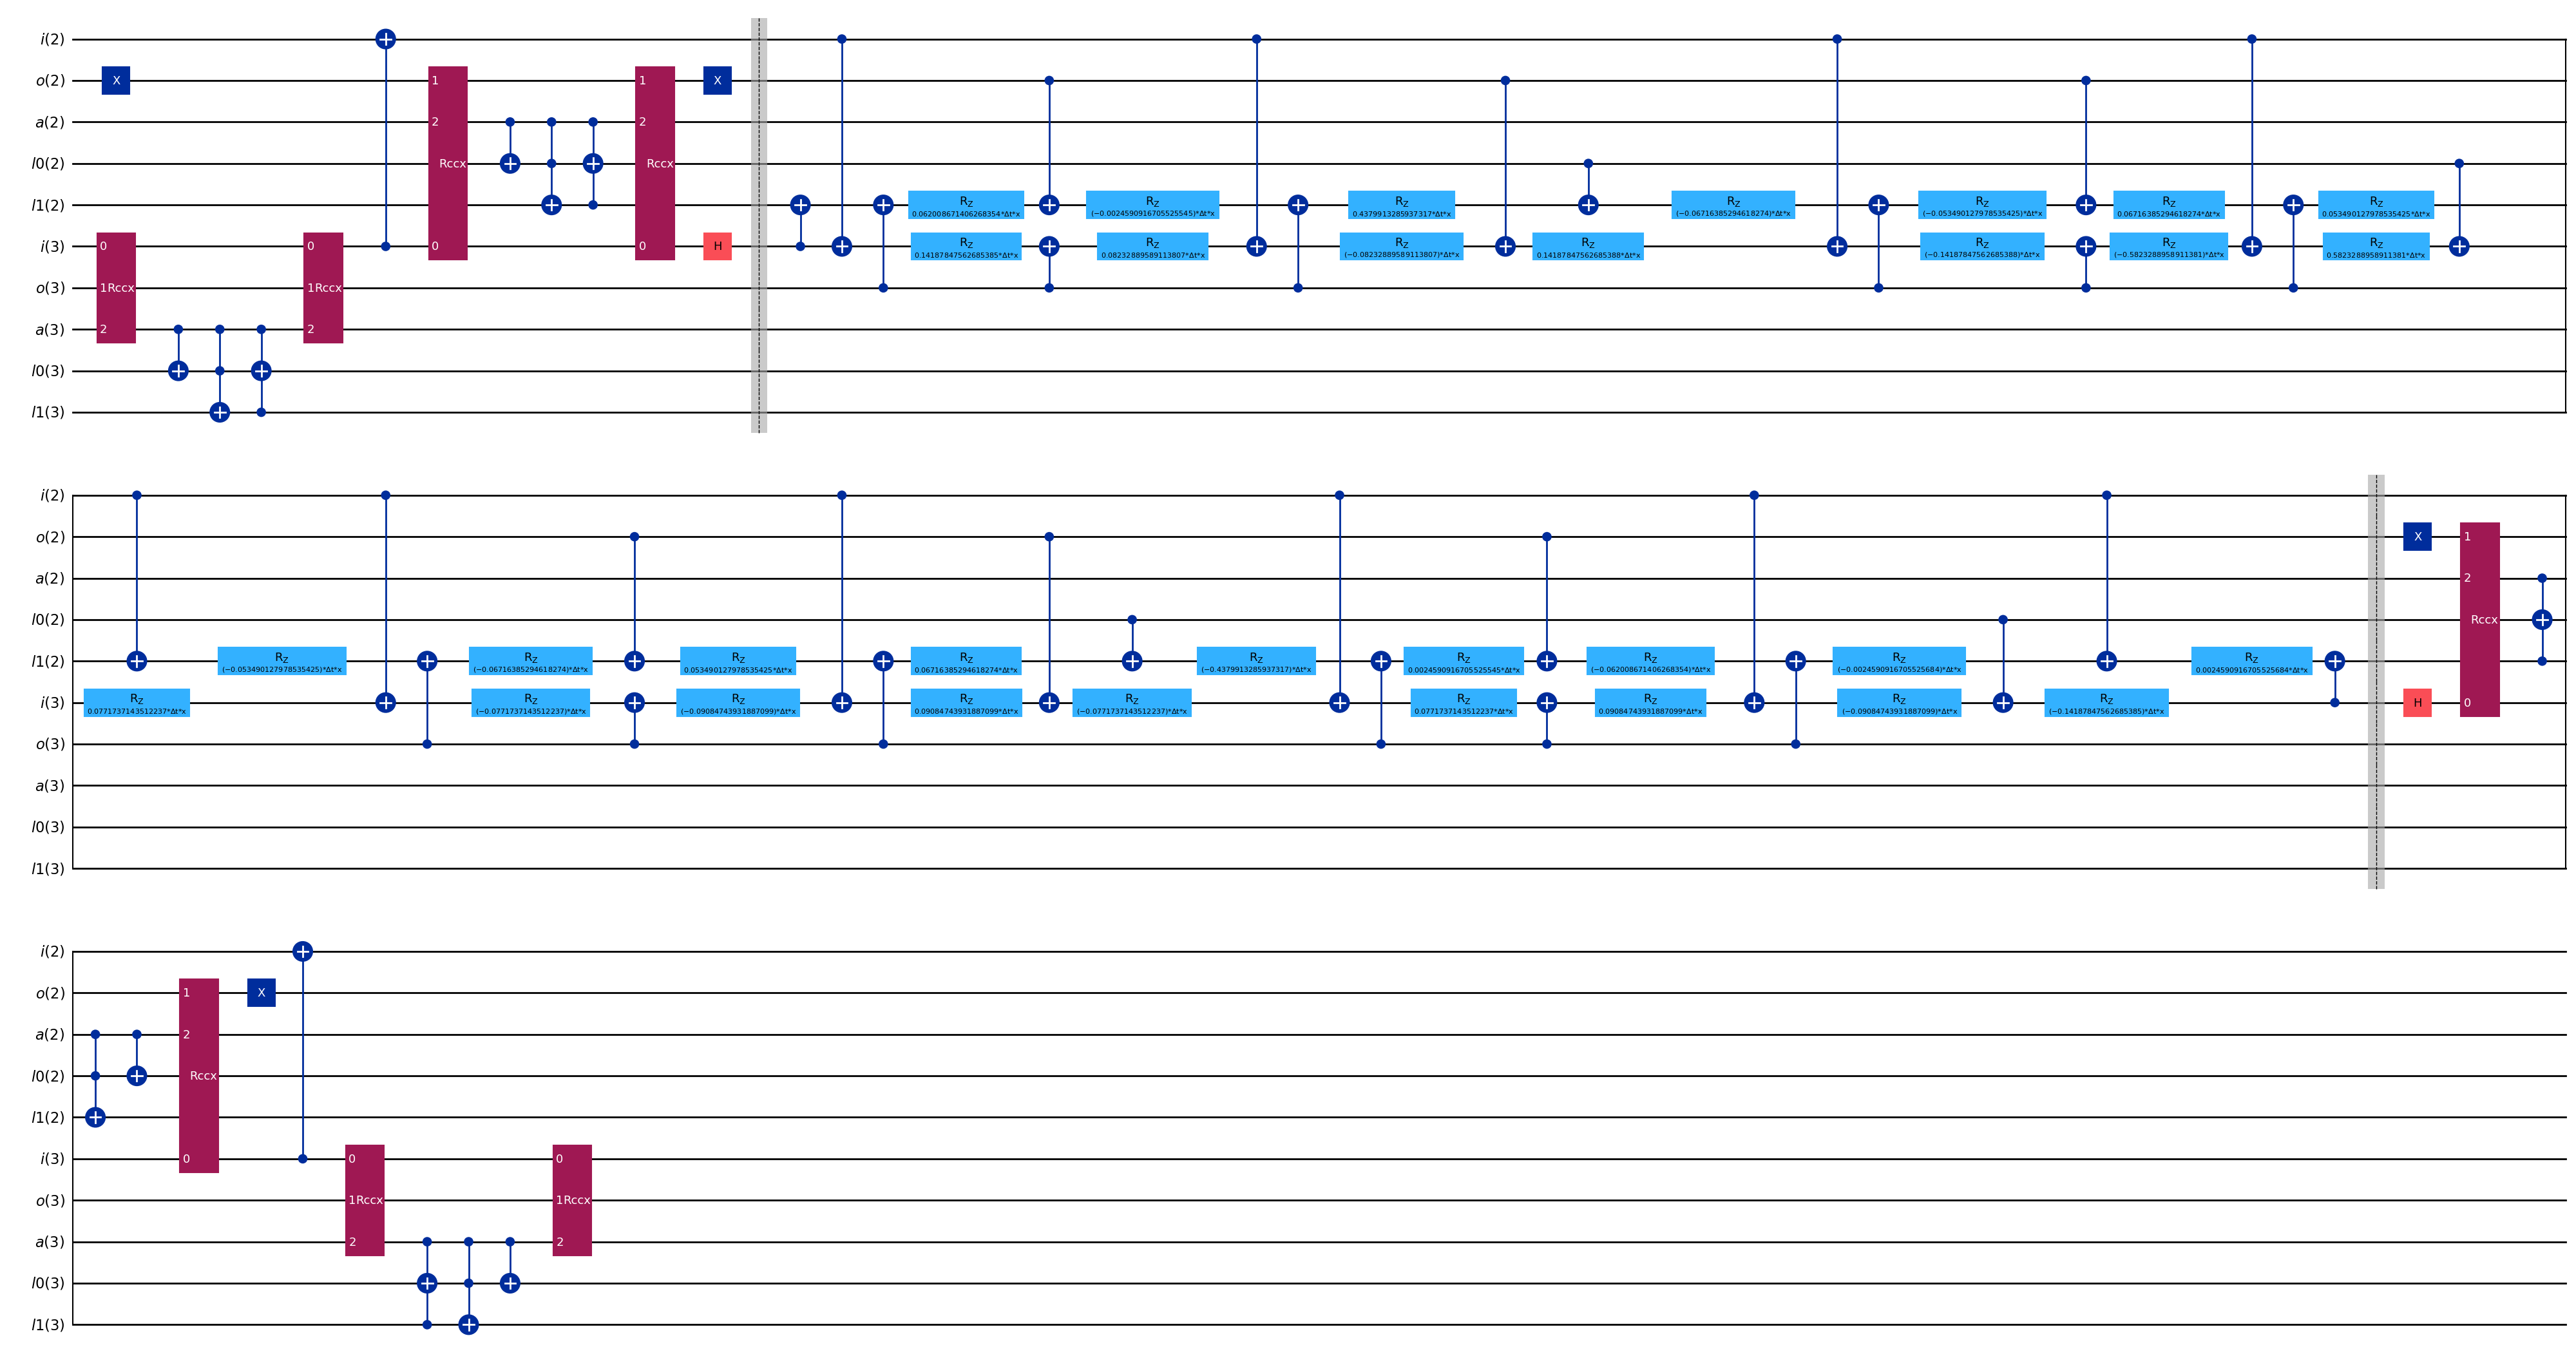

In [10]:
circuit = hopping_term_site(time_step, 1, interaction_x, with_barrier=True)
circuit = prune_circuit(circuit, site_idx=[2, 3])
circuit.draw('mpl', fold=60)

#### $r=2,3$ validation

In [11]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
hdt = hopping_site_hamiltonian(1, x) * dt
states = physical_states(num_sites=2, as_multi=True, boson_binary=True)
validate_circuit(assigned, hdt, ancillae=(2, 7), subspace=tuple(states[:, ::-1].T))

True

#### $r=4$ circuit

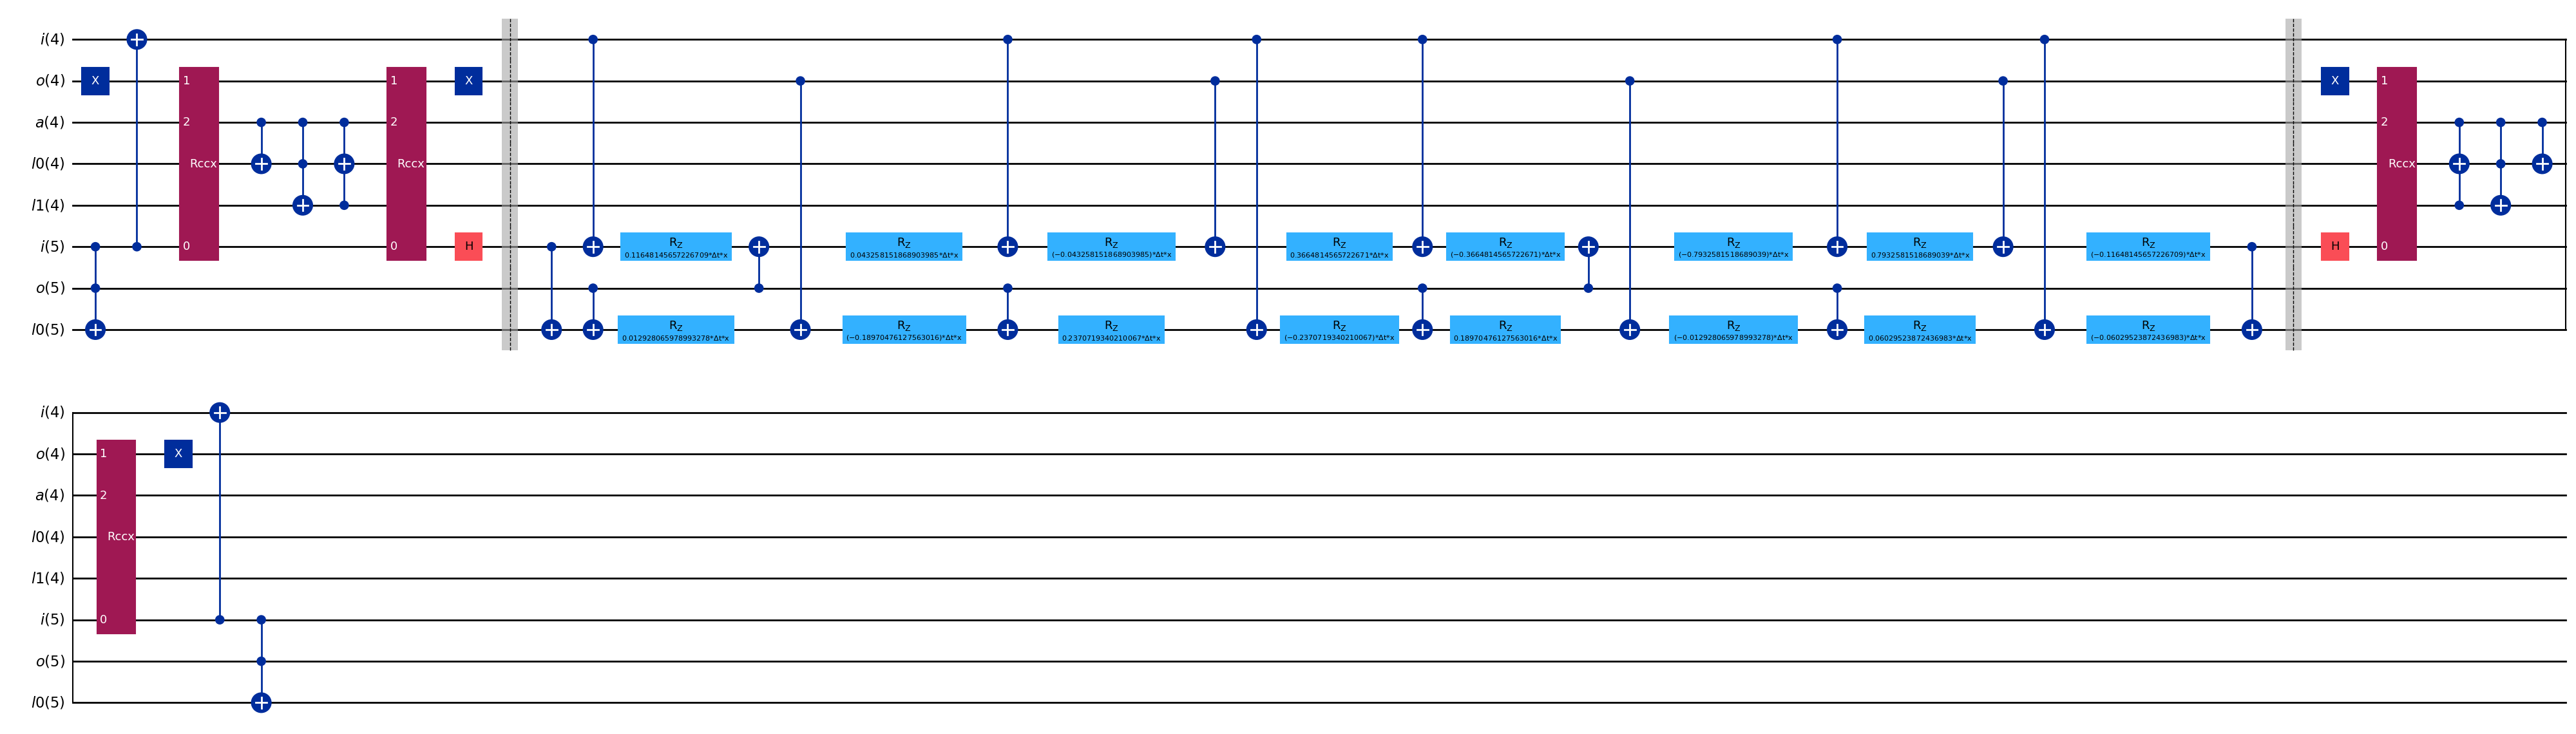

In [12]:
circuit = hopping_term_site(time_step, 1, interaction_x, max_right_flux=1, with_barrier=True)
circuit = prune_circuit(circuit, site_idx=[4, 5])
circuit.draw('mpl', fold=60)

#### $r=5$ circuit

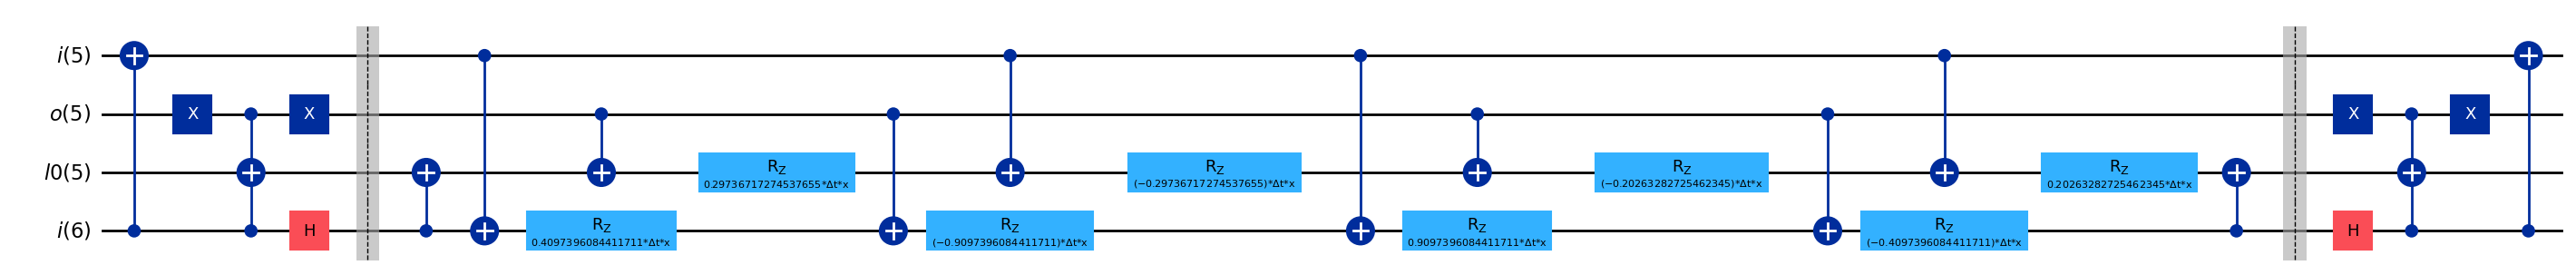

In [13]:
circuit = hopping_term_site(time_step, 1, interaction_x, max_right_flux=0, with_barrier=True)
circuit = prune_circuit(circuit, site_idx=[5, 6])
circuit.draw('mpl', fold=60)

#### $r=5$ validation

In [14]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
assigned = QuantumCircuit(5).compose(assigned, qubits=[0, 1, 2, 3])
hdt = hopping_site_hamiltonian(1, x, max_right_flux=0) * dt
states = physical_states(max_right_flux=0, num_sites=2, as_multi=True, boson_binary=True)
states = states[:, [0, 1, 2, 4, 5]]
validate_circuit(assigned, hdt, subspace=tuple(states[:, ::-1].T))

True

### $H_I^{(2)}$

#### $r=0$ circuit

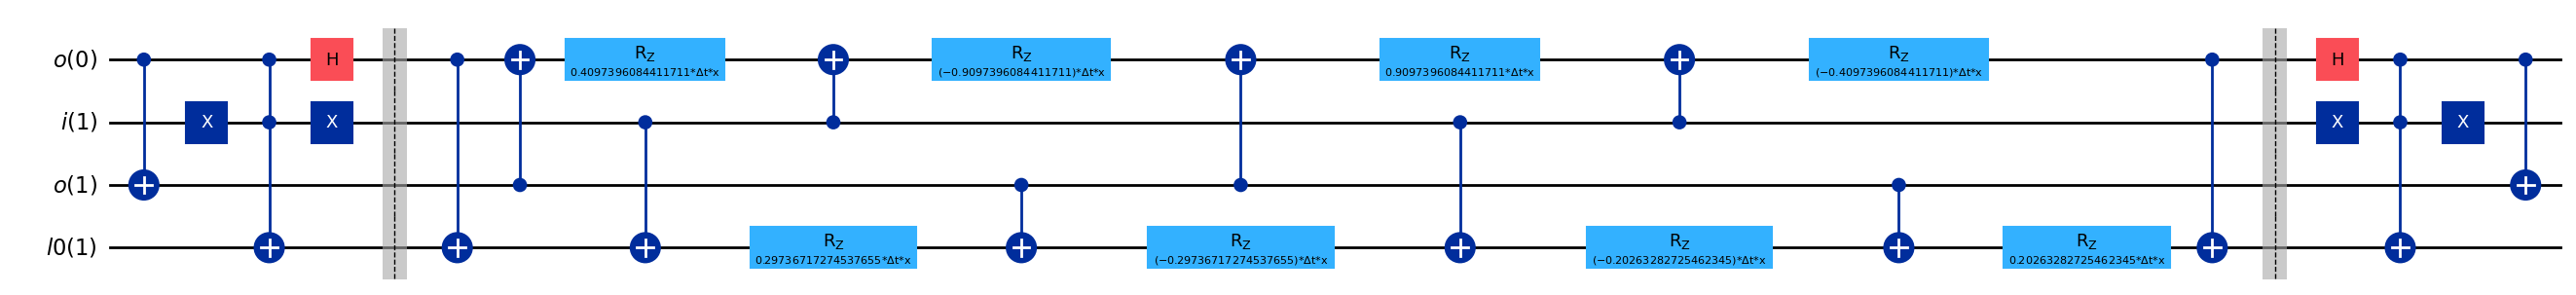

In [15]:
circuit = hopping_term_site(time_step, 2, interaction_x, max_left_flux=0, with_barrier=True)
circuit = prune_circuit(circuit)
circuit.draw('mpl', fold=60)

#### $r=1$ circuit

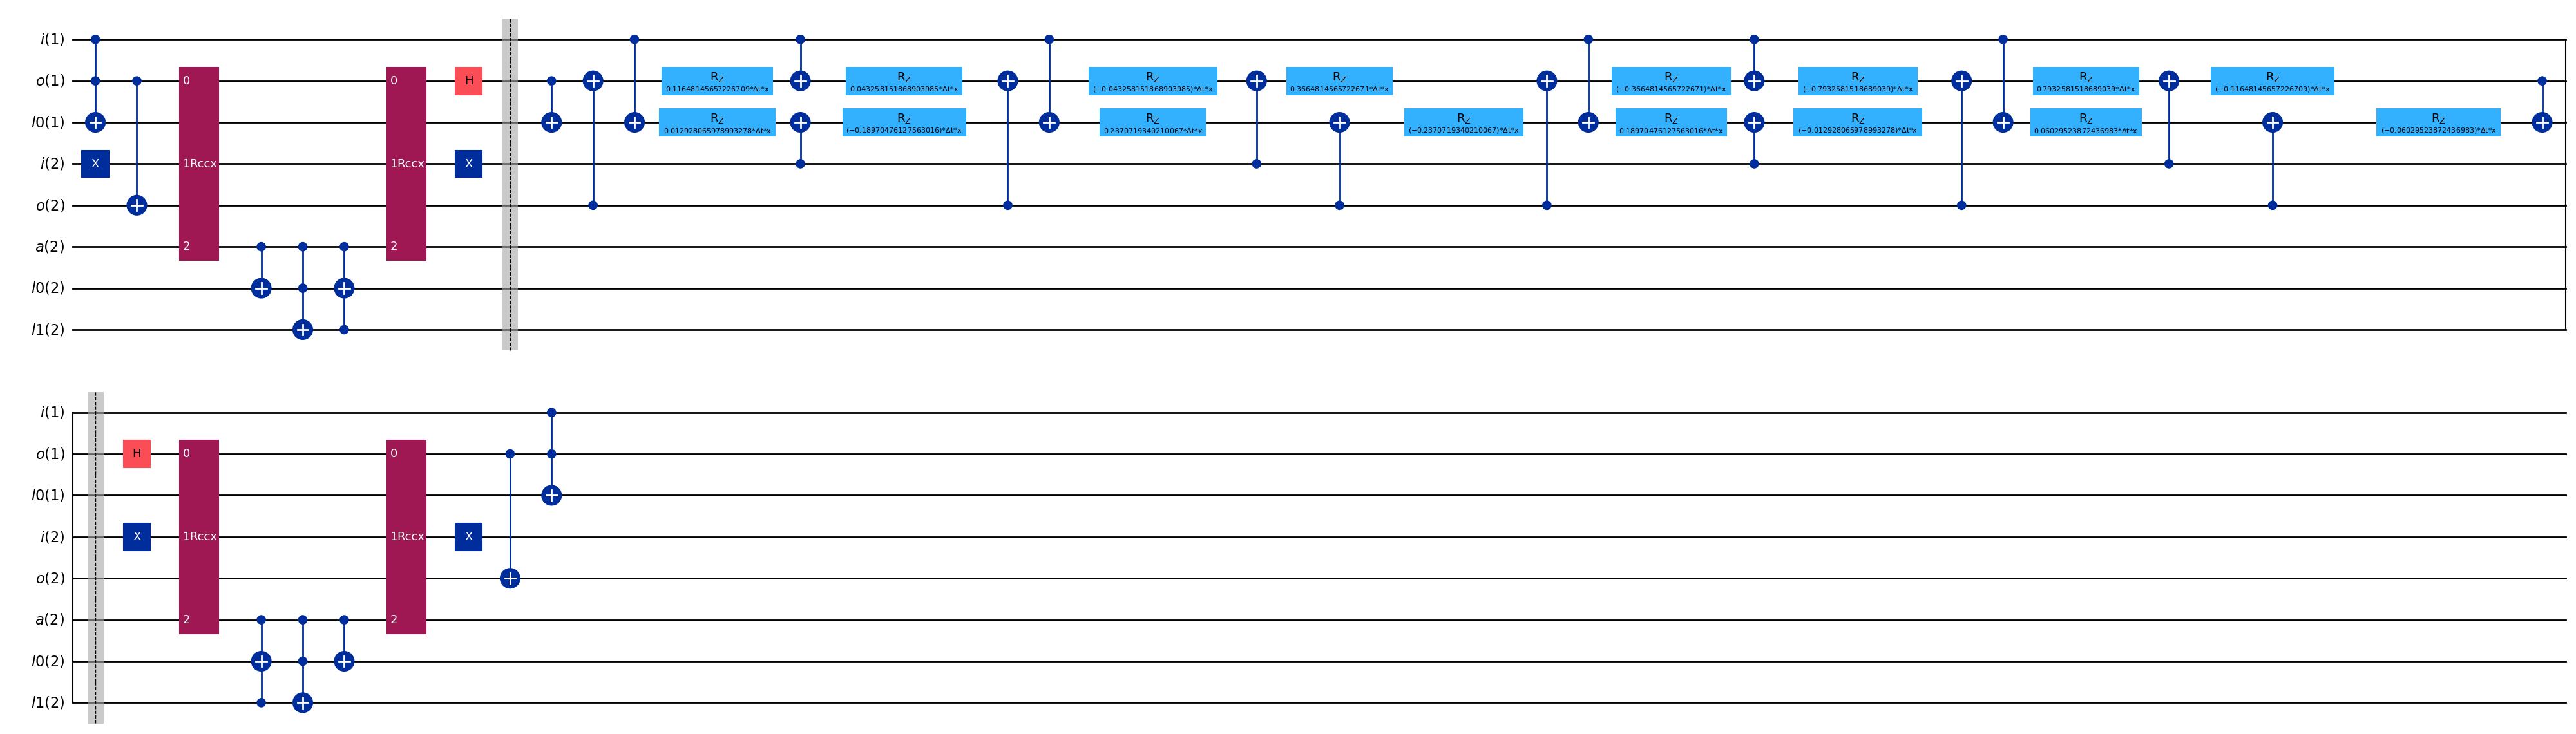

In [16]:
circuit = hopping_term_site(time_step, 2, interaction_x, max_left_flux=1, with_barrier=True)
circuit = prune_circuit(circuit, site_idx=[1, 2])
circuit.draw('mpl', fold=60)

#### $r=2,3$ circuit

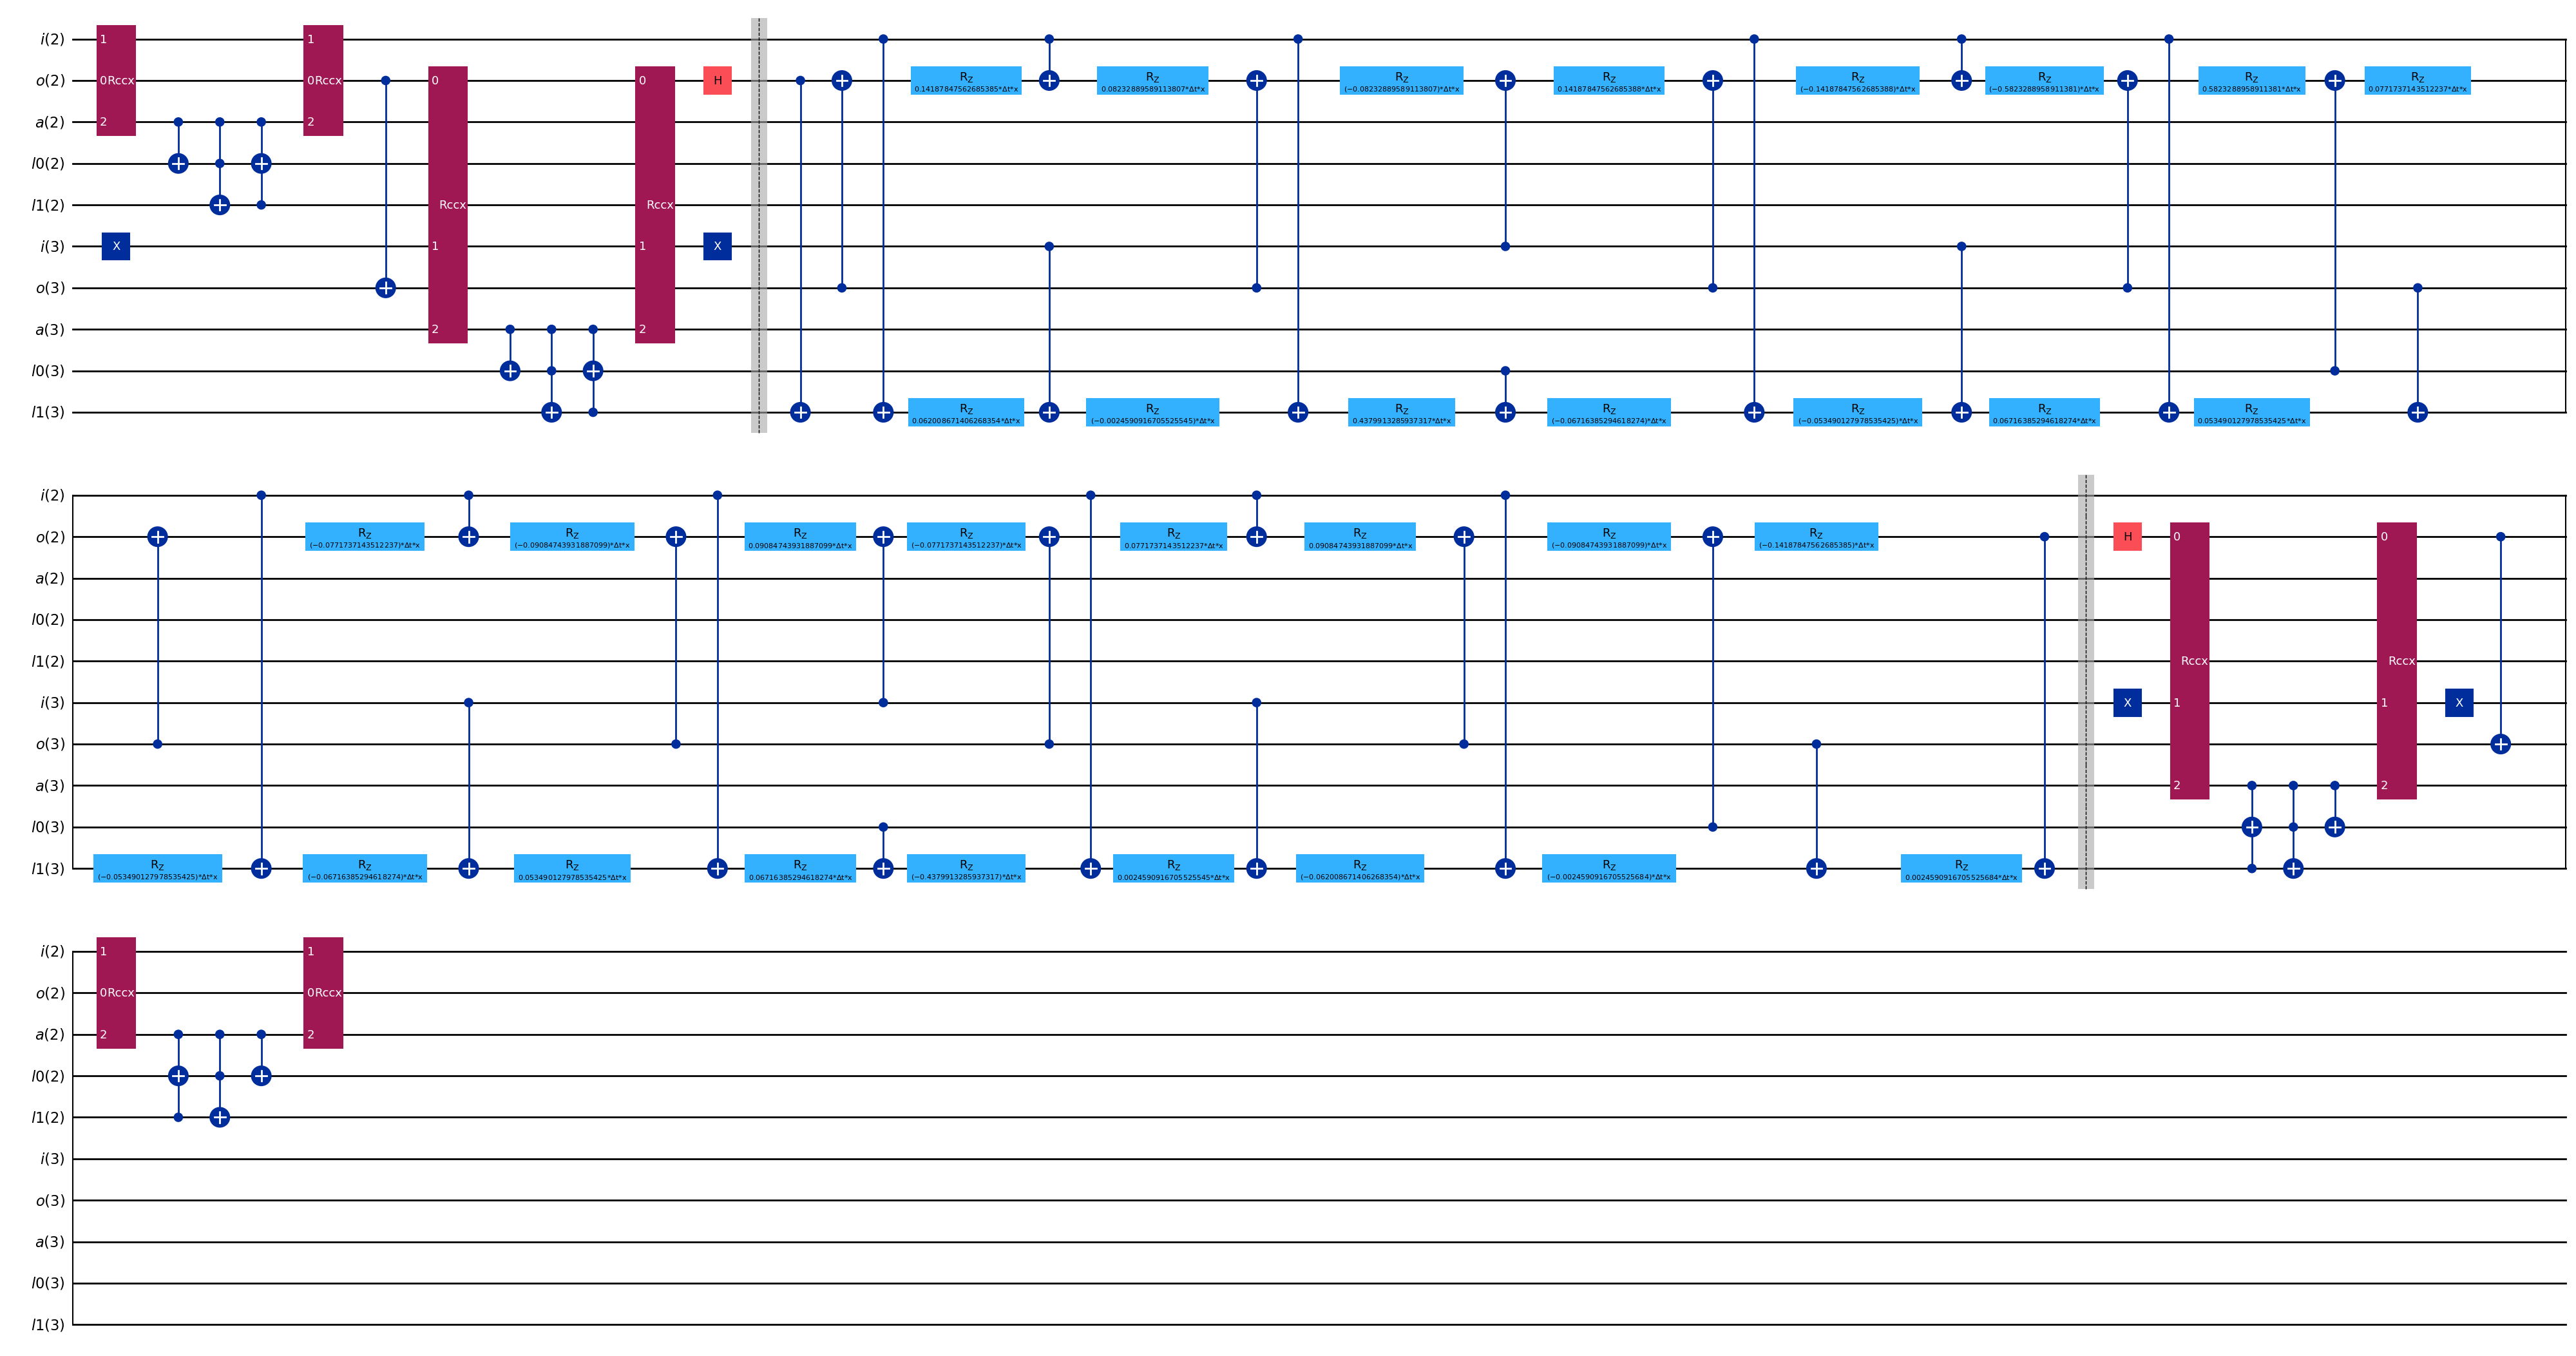

In [17]:
circuit = hopping_term_site(time_step, 2, interaction_x, with_barrier=True)
circuit = prune_circuit(circuit, site_idx=[2, 3])
circuit.draw('mpl', fold=60)

#### $r=2,3$ validation

In [18]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
hdt = hopping_site_hamiltonian(2, x) * dt
states = physical_states(num_sites=2, as_multi=True, boson_binary=True)
validate_circuit(assigned, hdt, ancillae=(2, 7), subspace=tuple(states[:, ::-1].T))

True

#### $r=4$ circuit

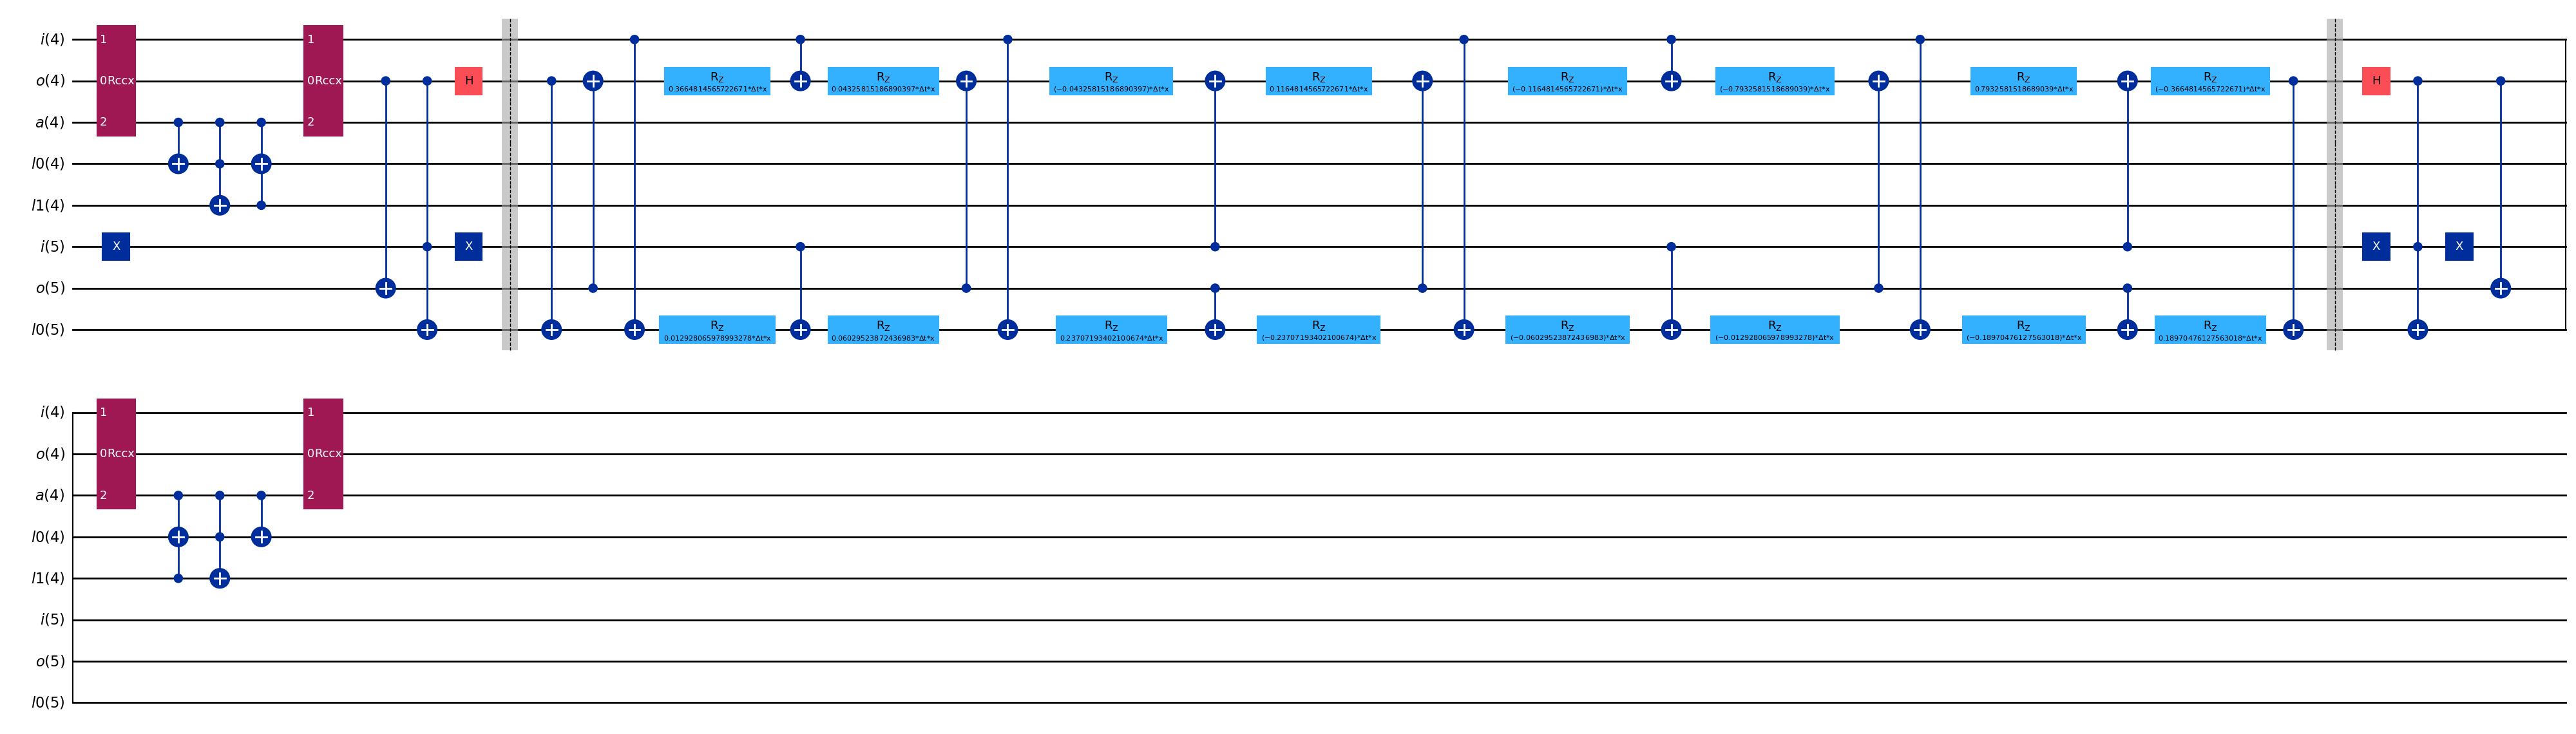

In [19]:
circuit = hopping_term_site(time_step, 2, interaction_x, max_right_flux=1, with_barrier=True)
circuit = prune_circuit(circuit, site_idx=[4, 5])
circuit.draw('mpl', fold=60)

#### $r=5$ circuit

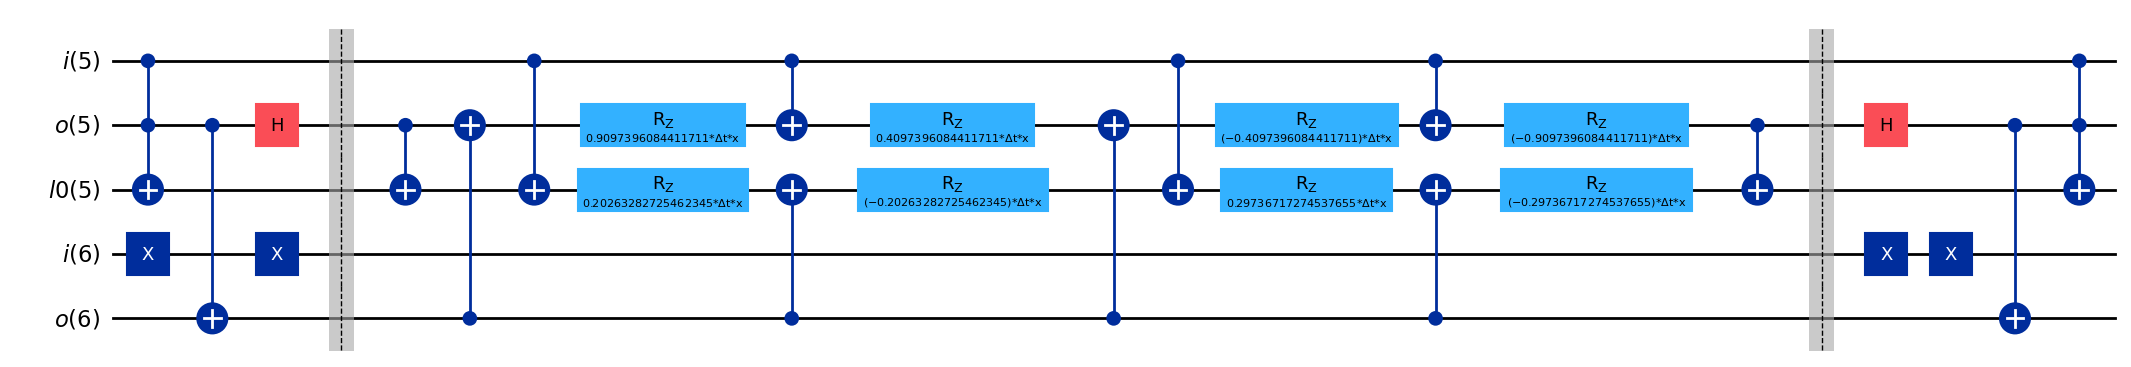

In [20]:
circuit = hopping_term_site(time_step, 2, interaction_x, max_right_flux=0, with_barrier=True)
circuit = prune_circuit(circuit, site_idx=[5, 6])
circuit.draw('mpl', fold=60)

#### $r=5$ validation

In [21]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
hdt = hopping_site_hamiltonian(2, x, max_right_flux=0) * dt
states = physical_states(max_right_flux=0, num_sites=2, as_multi=True, boson_binary=True)
states = states[:, [0, 1, 2, 4, 5]]
validate_circuit(assigned, hdt, subspace=tuple(states[:, ::-1].T))

True

## Full Hamiltonian (first-order Trotter)

### Circuit

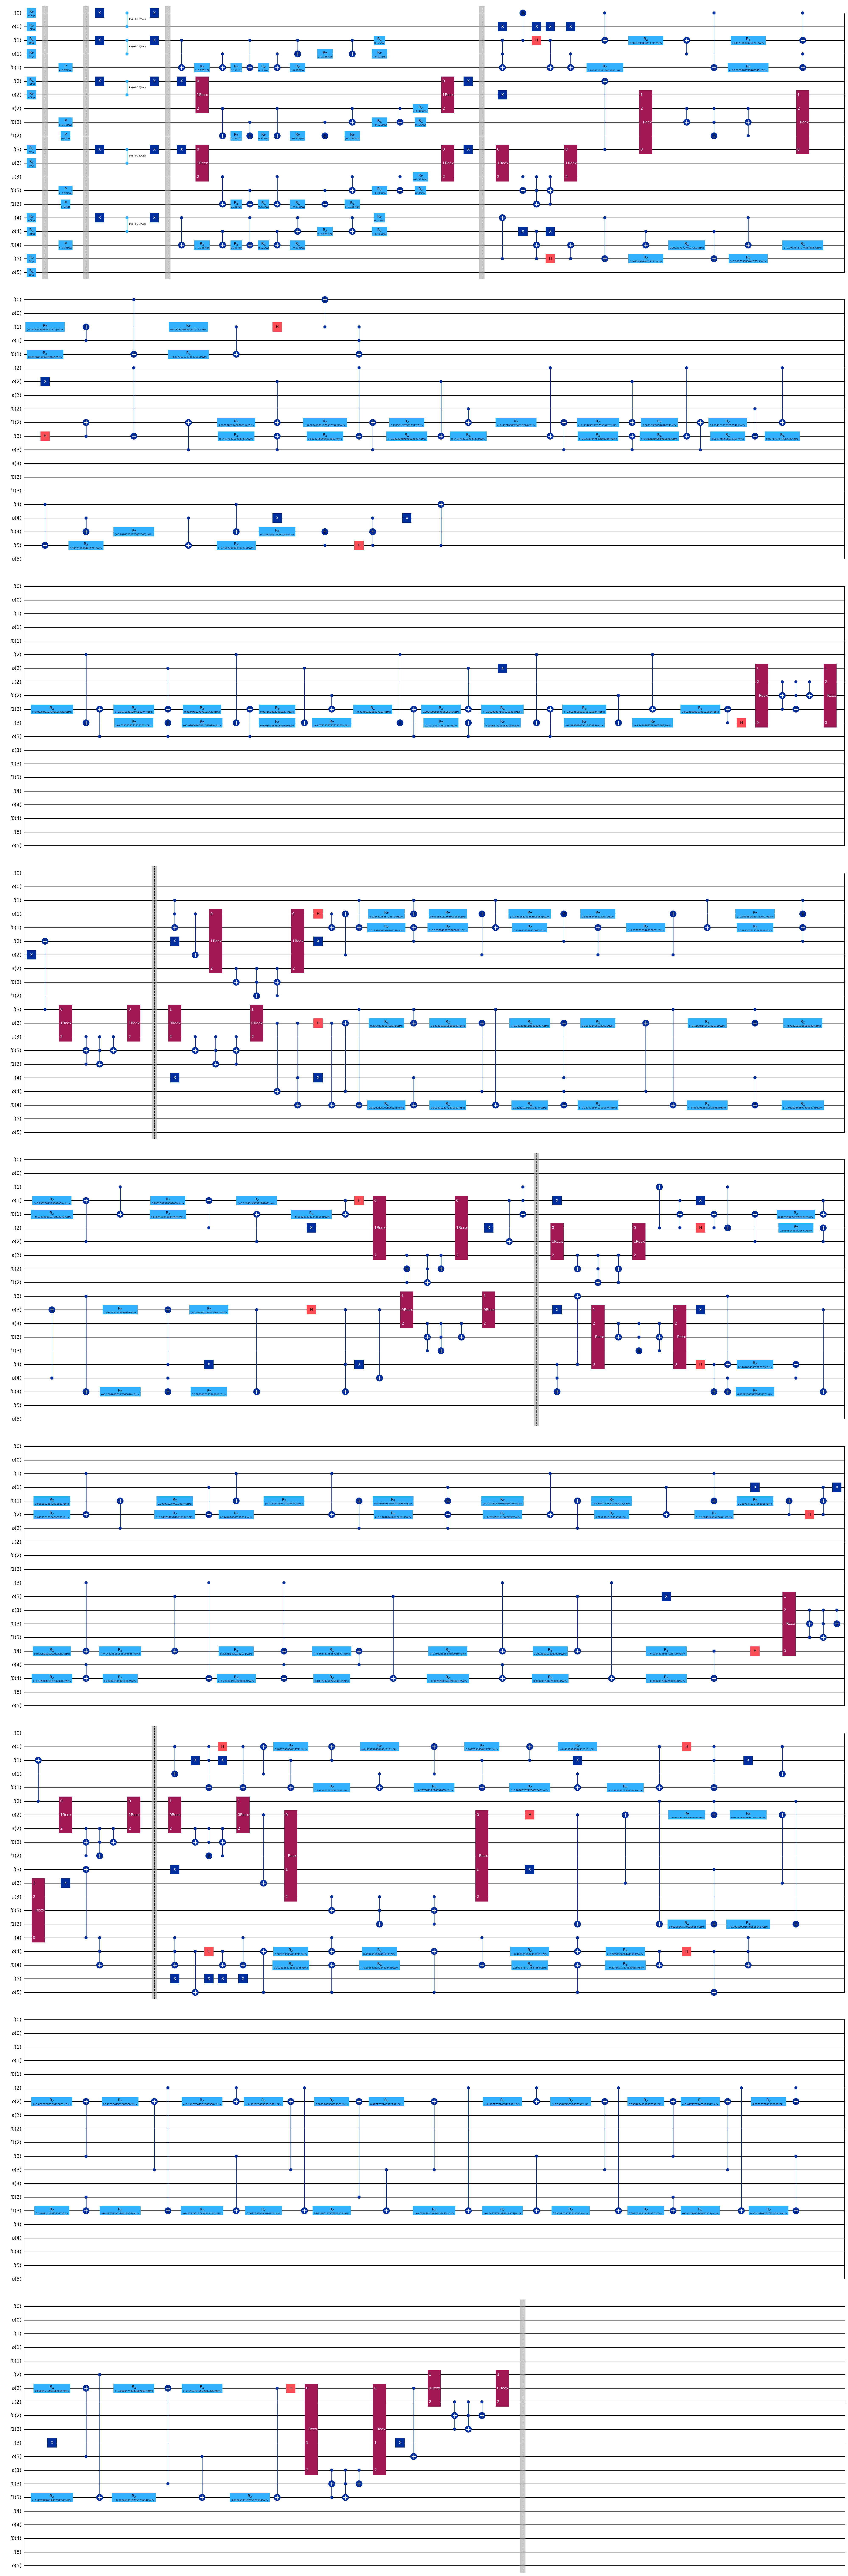

In [22]:
full_circuit = trotter_step_circuit(num_sites, time_step, mass_mu, interaction_x,
                                    max_left_flux=0, max_right_flux=0, with_barrier=True)
full_circuit = prune_circuit(full_circuit)
full_circuit.draw('mpl', fold=60)

In [29]:
precompile_pm = lsh_qudit_precompiler()
precompiled = precompile_pm.run(full_circuit)
precompiled.count_ops()

OrderedDict([('cx', 766),
             ('rz', 551),
             ('h', 120),
             ('t', 72),
             ('tdg', 72),
             ('x', 42),
             ('p', 6)])

In [30]:
precompiled.draw('mpl', fold=60)